# IFCNN Experiments

## Model Definition

In [1]:
import torch
from torch import nn
from torchvision import models


class Conv2dBlock(nn.Module):
    """Convolutional block applicable to image batches of size N×C×H×W"""

    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, *args, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor, /) -> torch.Tensor:
        y = self.conv(x)
        y = self.bn(y)
        y = self.relu(y)
        return y


class Fusor:
    """Fusor applicable to image batches of size N×F×C×H×W"""

    def __init__(self, fusion_mode: str = "max"):
        self.fusion_mode = fusion_mode

        match self.fusion_mode:
            case "max":
                self.fuse = Fusor.max
            case "amax":
                self.fuse = Fusor.amax
            case "sum":
                self.fuse = Fusor.sum
            case "mean":
                self.fuse = Fusor.mean
            case _:
                raise ValueError(f"Invalid fusion mode '{self.fusion_mode}'")

    def __call__(self, x: torch.Tensor, /) -> torch.Tensor:
        return self.fuse(x)

    @staticmethod
    def max(x: torch.Tensor, /) -> torch.Tensor:
        # Propagate gradient selectively in case of equal values
        return torch.max(x, 1).values

    @staticmethod
    def amax(x: torch.Tensor, /) -> torch.Tensor:
        # Distribute gradient evenly in case of equal values
        return torch.amax(x, 1)

    @staticmethod
    def sum(x: torch.Tensor, /) -> torch.Tensor:
        return torch.sum(x, 1)

    @staticmethod
    def mean(x: torch.Tensor, /) -> torch.Tensor:
        return torch.mean(x, 1)


class IFCNN(nn.Module):
    """Image-fusion convolutional neural network applicable to image batches of size N×F×C×H×W"""

    def __init__(self, in_channels: int = 1, fusion_mode: str = "max", use_resnet: bool = True):
        super().__init__()
        self.in_channels = in_channels
        self.fusion_mode = fusion_mode
        self.use_resnet = use_resnet

        self.extractor = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, 7, padding=3, padding_mode="replicate", bias=False),
            Conv2dBlock(64, 64, 3, padding=1, padding_mode="replicate", bias=False)
        )
        self.fusor = Fusor(self.fusion_mode)
        self.reconstructor = nn.Sequential(
            Conv2dBlock(64, 64, 3, padding=1, padding_mode="replicate", bias=False),
            nn.Conv2d(64, self.in_channels, 1)
        )
        self.apply(self.init_weight)

    @torch.no_grad()
    def init_weight(self, module: nn.Module, /):
        if not isinstance(module, nn.Conv2d):
            return
        if self.use_resnet and module.in_channels == self.in_channels:
            weight = models.resnet101(weights=models.ResNet101_Weights.DEFAULT).conv1.weight
            if module.in_channels == 1:
                weight = weight.sum(1, keepdim=True)
            module.weight = nn.Parameter(weight, requires_grad=False)
            return
        # Apply Kaiming initialization
        fan_out = module.out_channels
        for kernel_size in module.kernel_size:
            fan_out *= kernel_size
        module.weight.normal_(0.0, (2.0 / fan_out) ** 0.5)

    def forward(self, x: torch.Tensor, /) -> torch.Tensor:
        n, f = x.size(0), x.size(1)
        y = x.flatten(0, 1)  # Size (n*f, c, h, w)
        y = self.extractor(y)  # Size (n*f, 64, h, w)
        y = y.unflatten(0, (n, f))  # Size (n, f, 64, h, w)
        y = self.fusor(y)  # Size (n, 64, h, w)
        y = self.reconstructor(y)  # Size (n, c, h, w)
        return y

In [2]:
# Perform sanity checks
batch = torch.rand(8, 2, 1, 256, 256)

In [3]:
model = IFCNN(fusion_mode="sum")
model(batch).shape

torch.Size([8, 1, 256, 256])

In [4]:
model = IFCNN(in_channels=3, use_resnet=False)
model(torch.cat((batch, batch, batch), 2)).shape

torch.Size([8, 3, 256, 256])

## Feature Extraction

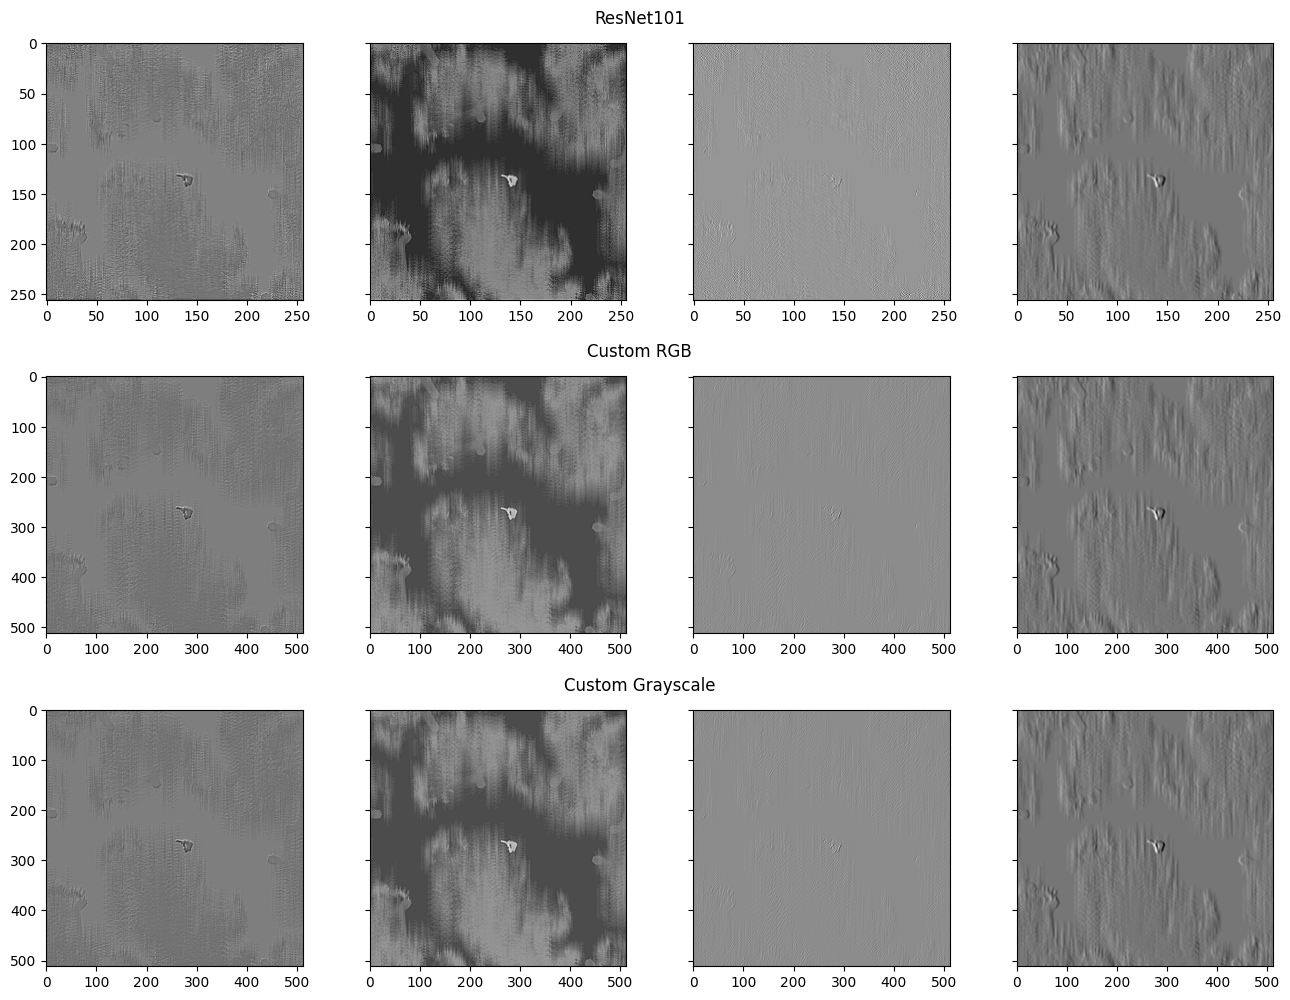

In [5]:
from matplotlib.pyplot import figure
from PIL import Image
from torchvision.transforms import ToTensor
from torchvision.models import resnet101, ResNet101_Weights


# Move position of window
START = 8

# Apply three individual layers
convs = (
    resnet101(weights=ResNet101_Weights.DEFAULT).conv1,
    IFCNN(in_channels=3).extractor[0],
    IFCNN().extractor[0]
)
img = ToTensor()(Image.open("integrals/14_integral.tiff"))
imgs = (img, img, img[[0]])
outs = (conv(img) for conv, img in zip(convs, imgs))
titles = ("ResNet101", "Custom RGB", "Custom Grayscale")

# Plot results
fig = figure(figsize=(16, 10))
subfigs = fig.subfigures(3, 1)

for subfig, out, title in zip(subfigs, outs, titles):
    axes = subfig.subplots(1, 4, sharey=True)
    subfig.suptitle(title)
    for axis, img in zip(axes, out[START:]):
        axis.imshow(img.moveaxis(0, -1).detach().numpy(), cmap="gray")

fig.show()

## Integer-Based Experiments

In [6]:
# Generate dummy batch
batch_gray = torch.randint(0, 256, (16, 1, 256, 256), dtype=torch.float)
batch_gray.shape

torch.Size([16, 1, 256, 256])

In [7]:
# Convert dummy batch to RGB
batch_rgb = torch.cat((batch_gray, batch_gray, batch_gray), 1)
batch_rgb.shape

torch.Size([16, 3, 256, 256])

In [8]:
# Generate dummy weight
weight_rgb = torch.randint(-5, 5, (64, 3, 7, 7), dtype=torch.float)
weight_rgb.shape

torch.Size([64, 3, 7, 7])

In [9]:
# Reduce dummy weight to grayscale
weight_gray = weight_rgb.sum(1, keepdim=True)
weight_gray.shape

torch.Size([64, 1, 7, 7])

In [10]:
# Create RGB layer
conv_rgb = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
conv_rgb.weight = nn.Parameter(weight_rgb, requires_grad=False)
sum(p.numel() for p in conv_rgb.parameters())

9408

In [11]:
# Create grayscale layer
conv_gray = nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False)
conv_gray.weight = nn.Parameter(weight_gray, requires_grad=False)
sum(p.numel() for p in conv_gray.parameters())

3136

In [12]:
# Verify theoretical equivalence
out_rgb = conv_rgb(batch_rgb)
out_gray = conv_gray(batch_gray)
torch.equal(out_rgb, out_gray)

True

In [13]:
# Measure runtime of RGB layer
%timeit conv_rgb(batch_rgb)

268 ms ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
# Measure runtime of grayscale layer
%timeit conv_gray(batch_gray)

161 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Floating-Point Experiments using ResNet

In [15]:
# Generate dummy batch
batch_gray = torch.rand(64, 1, 512, 512)
batch_gray.shape

torch.Size([64, 1, 512, 512])

In [16]:
# Convert dummy batch to RGB
batch_rgb = torch.cat((batch_gray, batch_gray, batch_gray), 1)
batch_rgb.shape

torch.Size([64, 3, 512, 512])

In [17]:
# Load ResNet layer
conv_resnet = models.resnet101(weights=models.resnet.ResNet101_Weights.DEFAULT).conv1
sum(p.numel() for p in conv_resnet.parameters())

9408

In [18]:
# Recreate ResNet layer
conv_rgb = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
conv_rgb.weight = nn.Parameter(conv_resnet.weight)
sum(p.numel() for p in conv_rgb.parameters())

9408

In [19]:
# Reduce ResNet layer to grayscale
conv_gray = nn.Conv2d(1, 64, 7, stride=2, padding=3, bias=False)
conv_gray.weight = nn.Parameter(conv_resnet.weight.sum(1, keepdim=True))
sum(p.numel() for p in conv_gray.parameters())

3136

In [20]:
# Verify theoretical equivalence
with torch.no_grad():
    out_resnet = conv_resnet(batch_rgb)
    out_rgb = conv_rgb(batch_rgb)
    out_gray = conv_gray(batch_gray)

In [21]:
torch.allclose(out_resnet, out_rgb)

True

In [22]:
# Observe numerical error due to single-precision floating-point arithmetic
torch.allclose(out_resnet, out_gray)

False

In [23]:
# Increase absolute tolerance to counteract floating-point error
torch.allclose(out_resnet, out_gray, atol=1e-05)

True

In [24]:
# Measure runtime of ResNet layer
%%timeit
with torch.no_grad():
    conv_resnet(batch_rgb)

4.15 s ± 2.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
# Measure runtime of RGB layer
%%timeit
with torch.no_grad():
    conv_rgb(batch_rgb)

3.21 s ± 474 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# Measure runtime of grayscale layer
%%timeit
with torch.no_grad():
    conv_gray(batch_gray)

2.45 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
